In [173]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

In [161]:
train_batch_size = 256#Define train batch size
test_batch_size  = 256#Define test batch size (can be larger than train batch size)

#load and split training set into training and cross validation sets. 
train_set, cv_set = torch.utils.data.random_split(
                             torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set,
  batch_size=train_batch_size, shuffle=True, drop_last=True)

cv_loader = torch.utils.data.DataLoader(cv_set,
  batch_size=train_batch_size, shuffle=True, drop_last=True)

#load test data
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True, drop_last=True)

In [162]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 6,
                          kernel_size=5, stride=1, padding=2)
        self.tanh1 = nn.Tanh()
        self.avg_pool1 = nn.AvgPool2d(kernel_size = 2, 
                                stride= 2)
        self.cnn2 = nn.Conv2d(in_channels =6, out_channels = 16, 
                             kernel_size = 5, stride = 1, padding=0)
        self.tanh2= nn.Tanh()
        self.avg_pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.cnn3 = nn.Conv2d(in_channels = 16, out_channels = 120,
                             kernel_size = 5, stride = 1)
        self.tanh3 = nn.Tanh()
        self.fc2 = nn.Linear(120,84)
        self.tanh4 = nn.Tanh()
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        #Define forward pass
        out = self.cnn1(x)
        out = self.tanh1(out)
        out = self.avg_pool1(out)
        out = self.cnn2(out)
        out = self.tanh2(out)
        out = self.avg_pool2(out)
        out = (torch.tanh(torch.flatten(self.cnn3(out))))
        out = torch.reshape(out, (train_batch_size,1,120))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        out = torch.reshape(out, (train_batch_size,10))
        output= F.softmax(out,dim=1)
        return output   
    
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [163]:
epochs = 10
accuracy_list = np.zeros((epochs,))
train_losses = []
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(train_batch_size,1,28,28))
        optimizer.zero_grad()
        out = model(train)
        loss = loss_fn(out,labels)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for i, (images, labels) in enumerate(cv_loader):
            train = Variable(images.view(test_batch_size,1,28,28))
            labels = Variable(labels)
            y_pred = model(train)
            correct += (torch.argmax(y_pred, dim=1) == labels).sum()
        accuracy = correct / 9984
        accuracy_list[epoch] = accuracy  
        correct = 0

([<matplotlib.axis.YTick at 0x1d9df5ec9d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

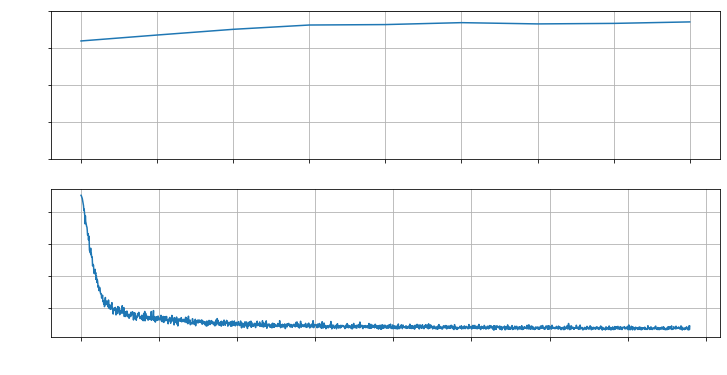

In [167]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)
ax1.plot(accuracy_list[1:])
ax1.set_ylabel("Test Accuracy", color='w')
ax1.set_xlabel("Epochs", color='w')
ax1.grid()
ax1.tick_params(labelcolor='w')
ax2.plot(train_losses)
ax2.set_ylabel("Training Loss", color='w')
ax2.set_xlabel("Training Samples (batch size of 256)", color='w')
ax2.tick_params(labelcolor='w')
ax2.grid()
plt.sca(ax1)
plt.yticks(np.arange(0.8,1.05, step=0.05))

In [166]:
print(accuracy_list)

[0.93129998 0.95910001 0.96710002 0.97479999 0.9806     0.98119998
 0.98379999 0.98210001 0.98280001 0.98479998]


In [172]:
#This cell tests the model with the remaining, untouched data. 
accuracy_list_test = []
for i, (images, labels) in enumerate(test_loader):
        train = Variable(images.view(test_batch_size,1,28,28))
        labels = Variable(labels)
        y_pred = model(train)
        correct += (torch.argmax(y_pred, dim=1) == labels).sum()
accuracy = correct / 9984 #9984 accounts for the fact that the last 16 examples were dropped. 
accuracy_list_test.append(accuracy)
correct = 0
print(accuracy_list_test)

[tensor(0.9867)]
